In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
import DataGrabber
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

from utils import set_gpytorch_settings
#gpytorch.settings.max_cholesky_size
set_gpytorch_settings()

In [2]:
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

from gpytorch.constraints import Interval
from custom_kernel import noise_lower, noise_upper, noise_init

In [3]:
# Grab Data and create tensors
data_grab = DataGrabber.DataGrab()
wave_data = data_grab.grab_data()
y = torch.tensor(wave_data['Wave Height'].values.astype(np.float32)).cuda()
X = torch.tensor(wave_data['Time'].values.astype(np.float32)).cuda()
X = X.reshape(-1,1)

In [4]:
# Standardize Data
X = (X - X.min(0).values) / (X.max(0).values - X.min(0).values)
y = y.log()
y = y - torch.min(y)
y = 2 * (y / torch.max(y)) - 1
# Training vs test
from math import floor
train_n = int(floor(0.7 * len(X)))
train_x = X[:train_n].contiguous().cuda()
train_y = y[:train_n].contiguous().cuda()
test_x = X[train_n:].contiguous().cuda()
test_y = y[train_n:].contiguous().cuda()

In [5]:
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [6]:
class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralDeltaGP(gpytorch.models.ExactGP):
    # def __init__(self, train_x, train_y, kernel, num_deltas, noise_init=None):
    #     likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
    #     likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
    #     likelihood.noise = 1e-2
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points)
        #variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        #super(SpectralDeltaGP, self).__init__(train_x, train_y, likelihood)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = kernel #gpytorch.kernels.SpectralDeltaKernel(num_dims=train_x.size(-1), num_deltas=num_deltas)
        #base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = kernel#gpytorch.kernels.ScaleKernel(base_covar_module)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [7]:
num_deltas = 300
kernel = (
        #ScaleKernel(AR2Kernel()) +
        #ScaleKernel(MinKernel()*RBFKernel()) +
        #ScaleKernel(MinKernel())+
        #ScaleKernel(RBFKernel()) +
        #ScaleKernel(RBFKernel()*LinearKernel())+
        ScaleKernel(MaternKernel(nu=0.5)) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=1e-4,
            upper_bound=0.1,
            initial_value=0.01
        ))) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=0.05,
            upper_bound=0.3,
            initial_value=0.15
        ))) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=0.25,
            upper_bound=1,
            initial_value=0.5
        ))) +
        ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(
            num_dims=train_x.size(-1),
            num_deltas=num_deltas,
        )) +
        ScaleKernel(gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4))

        #ScaleKernel(RBFKernel()*PeriodicKernel())
        )

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(noise_lower, noise_upper,initial_value=noise_init))

In [8]:
num_ind_pts = 300 # Number of inducing points (128 is default for train_and_test_approximate_gp function)

#m1, l1 = utils.train_and_test_approximate_gp(
#    StandardApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m2, l2 = utils.train_and_test_approximate_gp(
#     MeanFieldApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m3, l3 = utils.train_and_test_approximate_gp(
#     MAPApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m4, l4 = utils.train_and_test_approximate_gp(
#     OrthDecoupledApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m5, l5 = utils.train_and_test_approximate_gp(
#     SpectralDeltaGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_deltas)
# m6, l6 = utils.train_and_test_approximate_gp(
#     SpectralMixtureGPModel, kernel, *data_compact, num_epochs=100, num_ind_pts=num_deltas)
l1 = gpytorch.likelihoods.GaussianLikelihood()
m1 = SpectralMixtureGPModel(train_x, train_y, likelihood)




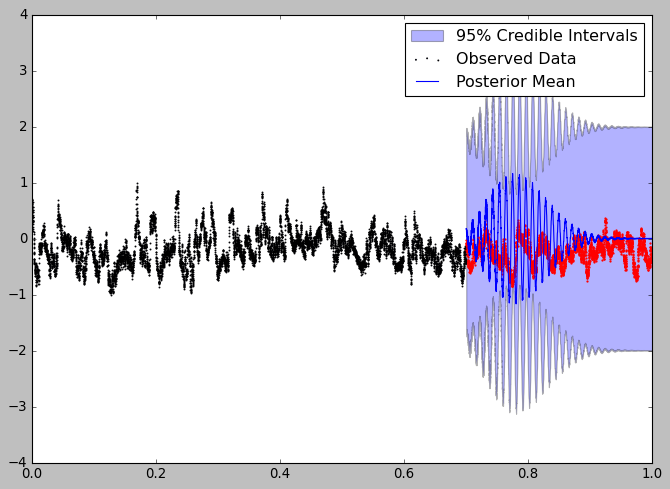

In [9]:
pairs = [[m1, l1],]
#         [m2, l2], [m3, l3],
#         [m4, l4], [m5, l5],
        #[m1, l1]]

for pair in pairs:
    model = pair[0]
    likelihood = pair[1]
    model.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x[:,0].detach().cpu().numpy(),
                    lower.detach().cpu().numpy(),
                    upper.detach().cpu().numpy(), alpha=0.3)
    # Plot training data as black stars
    ax.scatter(train_x[:,0].detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
    #ax.scatter(model.variational_strategy.inducing_points[:,0].detach().cpu().numpy(),
    #           np.zeros(500)+1, s=0.5)
    # Plot predictive means as blue line
    ax.plot(test_x[:,0].detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')
    ax.scatter(
        test_x[:,0].detach().cpu().numpy(),
        test_y.detach().cpu().numpy(),
        s=1, color="red")
    ax.set_xlim(0,1)
    #ax.set_xlim(0.65,0.75)
    #ax.vlines(m1.variational_strategy.inducing_points.detach().cpu().numpy(), ymin = -1.6, ymax = -1.5)

    #ax.set_ylim([0, 1.5])
    #ax.patch.set_facecolor('green')
    #ax.patch.set_alpha(.1)
    ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])

In [10]:
# for i in range(len(m1.covar_module.kernels)):
#     print(m1.covar_module.kernels[i].outputscale)

In [11]:
from utils import get_BIC

print(get_BIC(m1, likelihood, train_y, train_x))

RuntimeError: CUDA out of memory. Tried to allocate 1.25 GiB (GPU 0; 8.00 GiB total capacity; 6.25 GiB already allocated; 0 bytes free; 6.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
m1.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(m1(test_x))


In [ ]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 7))

# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.detach().cpu().numpy(),
                lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), alpha=0.3)
# Plot training data as black stars
ax.scatter(train_x.detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
# Plot predictive means as blue line
ax.plot(test_x.detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')

ax.set_ylim([0, 1.5])
#ax.patch.set_facecolor('green')
#ax.patch.set_alpha(.1)
ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])